In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Use Times New Roman for NAACL. 
font = {'family' : 'serif',
        'serif': 'Times New Roman',
        'size'   : 12,
       }
plt.rc('font', **font)

text = {
        'latex.unicode': True,
        'latex.preamble': r"\usepackage{times}"
        }
plt.rc('text', **text)

import itertools
linestyle = itertools.cycle(['-', '--', '-.', ':'])

In [16]:
import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [17]:
import shutil
import os
import json
import h5py

import pandas as pd
from sklearn.metrics import cohen_kappa_score, precision_recall_fscore_support
from sklearn.dummy import DummyClassifier
import modeling.utils

In [18]:
# For scikit learn metrics.
weighting = 'macro'

In [19]:
# To generate the data file used by this notebook, run the following on a machine with a GPU.
# Set the model directory.
#model_dir = 'models/keras/prepositions/convnet/20a7a6b088ee11e5b2b374d435ed6f3a/'
# Set the data file.
# data_file = 'data/preposition/prepositions-all-new-test.h5'
# Load the model, get predictions, and save output.
#modeling.utils.load_predict_save(model_dir, data_file)
# model, model_cfg = modeling.utils.load_model(model_dir, load_weights=True)

In [20]:
model_id = '20a7a6b088ee11e5b2b374d435ed6f3a'
basename = 'data/preposition/wikipedia/prepositions-all-new'
qualifier = '-test'
target_data_file = basename + '-target-data.json'

In [21]:
# Load model predictions and softmax probabilities.
pred_file = basename + qualifier + '-' + model_id + '-pred.h5'
f = h5py.File(pred_file, 'r')
preds = f['pred'].value
probs = f['prob'].value
f.close()

In [22]:
# Load model configuration (i.e. hyperparameters and other settings).
model_json_file = basename + qualifier + '-' + model_id + '-cfg.json'
model_json = json.load(open(model_json_file))
model_cfg = modeling.utils.ModelConfig(**model_json)

In [23]:
# Load target data or metadata (e.g. mapping between numeric target variable and preposition).
target_data = json.load(open(target_data_file))

In [24]:
# Load targets (multiclass, binary), examples (e.g. windows around a preposition, the entire sentence),
# and other data about the inputs (e.g. the length of each sentence).
data_file = basename + qualifier + '.h5'
model_data = modeling.utils.load_all_model_data(data_file, model_cfg)

[(999552, 5), (999552, 52)]


In [25]:
evens = np.arange(0, len(preds), 2)
odds = evens + 1

In [26]:
dummy_prior = DummyClassifier(strategy='prior', random_state=17)
dummy_prior.fit(model_data.data, model_data.target)
preds_prior = dummy_prior.predict(model_data.data)
probs_prior = dummy_prior.predict_proba(model_data.data)

dummy_uniform = DummyClassifier(strategy='uniform', random_state=17)
dummy_uniform.fit(model_data.data, model_data.target)
preds_uniform = dummy_uniform.predict(model_data.data)
probs_uniform = dummy_uniform.predict_proba(model_data.data)

Error judgments from annotators
=======

In [27]:
annotator_data_dir = os.environ['HOME'] + '/proj/dissertation/projects/cnn/data/preposition/annotations/'
annotator1_csv = annotator_data_dir + 'annotator01-results.csv'
annotator2_csv = annotator_data_dir + 'annotator02-results.csv'
annotator3_csv = annotator_data_dir + 'annotator03-results.csv'
annotator4_csv = annotator_data_dir + 'annotator04-results.csv'

corpus_annotator_id = 5
model_annotator_id = 6

def normalize_annotator_columns(annotator_df):
    """
    Rename columns of a data frame of annotator judgements.
    
    Parameters
    ----------
    annotator_df: pandas.DataFrame
        A data frame of annotator judgements.
    
    Returns
    ----------
    new_df: pandas.DataFrame
        A data frame containing the same data with columns renamed as follows:
          'Sentence id'         => 'sent_id'
          'Sentence'            => 'sentence'
          'Correct Preposition' => 'correct_preposition'
          'Confidence'          => 'confidence'
          'Sentence Quality'    => 'sent_quality'
    """
    rename_columns = {
            'Sentence id': 'sent_id',
            'Sentence': 'sentence',
            'Correct Preposition': 'correct_preposition',
            'Confidence': 'confidence',
            'Sentence Quality': 'sent_quality'
            }
    
    new_df = annotator_df.copy()
    
    for (old_column, new_column) in rename_columns.items():
        new_df[new_column] = new_df[old_column]
        del new_df[old_column]
        
    return new_df

def load_annotator_df(annotator_csv):
    """
    Load a data frame of annotator judgments.
    
    Parameters
    ----------
    annotator_csv : str
        Path to a .csv file containing annotator judgments.
    
    Returns
    -----------
    df : pandas.DataFrame
        A data frame of annotator judgments with normalized column names.
    """
    annotator_df = pd.read_csv(annotator_csv, sep='\t')
    annotator_df = normalize_annotator_columns(annotator_df.ix[:, 0:5])
    return annotator_df.sort('sent_id')

def sent_is_modified(sent_ids):
    return sent_ids > 30600000

def get_model_data_indices(annotator_df):
    """
    Because of how I sampled the sentences for the humans to annotate, the sentences
    in the annotator's data set with IDs < 30600000 are (presumably) error free, and
    those with IDs > 30600000 contain a preposition error.  For each sentence ID in
    the annotator's data set, I need to find the indices of the two positions in the
    test set used by the model, and select the first of the two indices (the one at
    an even-numbered index) if the sentence ID < 30600000 and use select the second
    of the two if the sentence ID > 30600000.
    
    Parameters
    --------
    annotator_df : pandas.DataFrame
        A data frame of annotator judgments.
        
    Returns
    ---------
    sent_id : list
        A list of indices for subscripting data loaded using `load_all_model_data`.
    """
    sent_ids = annotator_df['sent_id'].values
    annotator_evens = set(sent_ids[~sent_is_modified(sent_ids)])
    annotator_odds = set(sent_ids[sent_is_modified(sent_ids)])
    
    sent_idx = []

    for idx,sent_id in enumerate(model_data.sent_id):
        if idx % 2 == 0:
            if sent_id in annotator_evens:
                sent_idx.append(idx)
        elif sent_id in annotator_odds:
            sent_idx.append(idx)
            
    return sent_idx

def build_annotator(annotator_csv, target_data, annotator_id):
    df = load_annotator_df(annotator_csv)
    df['correct_preposition_code'] = [target_data['original_word_code']['names'].index(word)
                                 for word in df['correct_preposition']]
    df['annotator_id'] = annotator_id
    df['probability'] = None
    return df

def build_corpus_annotator(annotator_df, target_data, model_data, annotator_id=corpus_annotator_id):
    sent_idx = get_model_data_indices(annotator_df)
    sent_ids = sorted(np.unique(annotator_df.sent_id))
    
    df = pd.DataFrame({
            'sent_id': sent_ids,
            'annotator_id': [annotator_id] * len(sent_idx),
            'correct_preposition_code': model_data.target[sent_idx],
            'correct_preposition': [target_data['original_word_code']['names'][word]
                            for word in model_data.target[sent_idx]],
            'confidence': [None] * len(sent_idx),
            'sent_quality': [None] * len(sent_idx),
            'probability': [None] * len(sent_idx)
            })
    
    #print('corpus annotator', df.shape)
    
    return df
    
def build_model_annotator(annotator_df, target_data, preds, probs, annotator_id=model_annotator_id):
    sent_idx = get_model_data_indices(annotator_df)
    sent_ids = sorted(np.unique(annotator_df.sent_id))
    
    df = pd.DataFrame({
            'sent_id': sent_ids,
            'annotator_id': [annotator_id] * len(sent_ids),
            'correct_preposition_code': preds[sent_idx],
            'correct_preposition': [target_data['original_word_code']['names'][word]
                        for word in preds[sent_idx]],
            'confidence': [None] * len(sent_idx),
            'sent_quality': [None] * len(sent_idx),
            'probability': np.max(probs[sent_idx], axis=1)
        })
    
    #print('model annotator', df.shape)
                      
    return df

def build_kappa_comparator(column='correct_preposition'):
    def compute_kappa(df1, df2):
        return cohen_kappa_score(df1[column], df2[column])
    return compute_kappa

def build_annotators_df():
    annotator1_df = build_annotator(annotator1_csv, target_data, annotator_id=1)
    annotator2_df = build_annotator(annotator2_csv, target_data, annotator_id=2)
    annotator3_df = build_annotator(annotator3_csv, target_data, annotator_id=3)
    annotator4_df = build_annotator(annotator4_csv, target_data, annotator_id=4)
    
    annotator_df = pd.concat([annotator1_df, annotator2_df, annotator3_df, annotator4_df])
    sent_df = annotator_df[['sent_id', 'sentence']]
    del annotator_df['sentence']
    columns = sorted(annotator_df.columns)
    annotator_df = annotator_df[columns]

    corpus_df = build_corpus_annotator(annotator_df, target_data, model_data)[columns]
    model_df = build_model_annotator(annotator_df, target_data, preds, probs)[columns]

    df = pd.concat([annotator_df, corpus_df, model_df])
    df.sort('sent_id', inplace=True)
    
    sent_df.drop_duplicates(subset=['sent_id'], inplace=True)
    sent_df.sort('sent_id', inplace=True)
    
    return df, sent_df

In [28]:
annotator_names = {
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    corpus_annotator_id: 'corpus',
    model_annotator_id: 'model'
}

def compare_annotators(df, id1, id2, comparator):
    df1 = df[df.annotator_id == id1]
    df2 = df[df.annotator_id == id2]
    df2 = df2[df2.sent_id.isin(df1.sent_id)]
    df1 = df1[df1.sent_id.isin(df2.sent_id)]
    return comparator(df1, df2), len(df1)
    
def compute_annotator_kappas():
    df, _ = build_annotators_df()
    
    annotator1 = []
    annotator2 = []
    values = []
    ns = []
    kns = []
    
    comparator = build_kappa_comparator()
    pairs = itertools.combinations(annotator_names.keys(), 2)
    
    for pair in pairs:
        kappa, n = compare_annotators(df, pair[0], pair[1], comparator)
        names = [annotator_names[i] for i in pair]
        annotator1.extend(names)
        annotator2.extend(reversed(names))
        values.extend([kappa, kappa])
        ns.extend([n, n])
        kn = '{kappa:.2f} ({n})'.format(kappa=kappa, n=n)
        kns.extend([kn, kn])
        
    df_kappa = pd.DataFrame({
            'annotator 1': annotator1,
            'annotator 2': annotator2,
            'kappa': values,
            'n': ns,
            'kappan': kns
            })
    
    return df_kappa
    
df_kappa = compute_annotator_kappas()

df_kappa_pivot = df_kappa.pivot(index='annotator 1', columns='annotator 2', values='kappan')
np.fill_diagonal(df_kappa_pivot.values, '.')

print(df_kappa_pivot)
print('')
print(df_kappa_pivot.to_latex(float_format=lambda f: '%.02f' % f))

annotator 2           1           2           3           4       corpus  \
annotator 1                                                                
1                     .  0.83 (177)  0.72 (155)  0.70 (175)   0.78 (507)   
2            0.83 (177)           .  0.79 (163)  0.79 (179)   0.83 (519)   
3            0.72 (155)  0.79 (163)           .  0.77 (151)   0.80 (469)   
4            0.70 (175)  0.79 (179)  0.77 (151)           .   0.79 (505)   
corpus       0.78 (507)  0.83 (519)  0.80 (469)  0.79 (505)            .   
model        0.75 (507)  0.78 (519)  0.76 (469)  0.75 (505)  0.83 (1000)   

annotator 2        model  
annotator 1               
1             0.75 (507)  
2             0.78 (519)  
3             0.76 (469)  
4             0.75 (505)  
corpus       0.83 (1000)  
model                  .  

\begin{tabular}{lllllll}
\toprule
annotator 2 &           1 &           2 &           3 &           4 &       corpus &        model \\
\midrule
annotator 1 &             &   

In [29]:
def precision_recall_per_annotator():
    df, _ = build_annotators_df()
    
    precision = []
    recall = []
    f1 = []
    support = []
    preposition = []
    annotator = []
    
    for annotator_id in [1, 2, 3, 4, model_annotator_id]:
        # Get a data frame for just this annotator.
        annotator_df = df[df.annotator_id == annotator_id]
        
        # Get a data frame for the corpus itself.
        corpus_df = df[df.annotator_id == corpus_annotator_id].copy()
        
        # Retain only those rows in the corpus data frame for which the
        # given annotator provided a judgment.
        corpus_df = corpus_df[corpus_df.sent_id.isin(annotator_df.sent_id)]

        # Sort both data frames.
        annotator_df.sort('sent_id', inplace=True)
        corpus_df.sort('sent_id', inplace=True)
        
        p, r, f, s = precision_recall_fscore_support(
                corpus_df.correct_preposition,
                annotator_df.correct_preposition)
        
        precision.extend(p)
        recall.extend(r)
        f1.extend(f)
        support.extend(s)
        annotator.extend([annotator_id] * len(s))
        preposition.extend(target_data['original_word_code']['names'])
        
    return pd.DataFrame({
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'N': support,
            'Preposition': preposition,
            'Annotator': annotator
        })

def metric_rank_correlation(df, annotator1_id, annotator2_id, metric):
    import scipy.stats
    df = df.sort(['Annotator', 'Preposition'])
    return scipy.stats.spearmanr(
        df[df.Annotator == annotator1_id][metric],
        df[df.Annotator == annotator2_id][metric])

def annotator_metric_rank_correlation(pr_per_annotator_df, metric='F1'):
    df = pr_per_annotator_df.copy()
    df.sort(['Annotator', 'Preposition'], inplace=True)
    pairs = itertools.combinations(df.Annotator.unique(), 2)
    
    ranks = []
    ps = []
    annotator1 = []
    annotator2 = []
    
    for pair in pairs:
        rank, p = metric_rank_correlation(df, pair[0], pair[1], metric=metric)
        ranks.extend([rank, rank])
        ps.extend([p, p])
        names = [annotator_names[i] for i in pair]
        annotator1.extend(names)
        annotator2.extend(reversed(names))
        
    return pd.DataFrame({
            'Rank': ranks,
            'P': ps,
            'Annotator 1': annotator1,
            'Annotator 2': annotator2
            
        })

pr_per_annotator_df = precision_recall_per_annotator()
pr_per_annotator_df = pr_per_annotator_df.sort(['Annotator', 'F1'])[['Annotator', 'N', 'Preposition', 'F1', 'Precision', 'Recall']]
#pr_per_annotator_df

/Users/ndronen/miniconda/lib/python2.7/site-packages/pandas/core/frame.py:2915: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  inplace=inplace, kind=kind, na_position=na_position)


In [30]:
def plot_annotator_f1_vs_model(pr_per_annotator_df):
    df = pr_per_annotator_df.sort('Preposition')
    
    df_model = pr_per_annotator_df[df.Annotator == model_annotator_id]
    df_model.sort('Preposition')
    
    colors = ['red', 'blue', 'green']
    markers = ['o', 's', '*']
    plt.figure(figsize=(9,6))
    
    for i, annotator_id in enumerate([1, 2, 3]):
        df_annotator = pr_per_annotator_df[df.Annotator == annotator_id]
        df_annotator = df_annotator.sort('Preposition')
        plt.scatter(df_model.F1, df_annotator.F1,
                    label=str(annotator_id), c=colors[i],
                    marker=markers[i], s=60)
                    # linewidth=2)
    plt.xlabel('Model F1')
    plt.ylabel('Annotator F1')
    plt.xlim(0.71, 1)
    plt.ylim(0.71, 1)
    plt.legend(loc='lower right')
    
#plot_annotator_f1_vs_model(pr_per_annotator_df)

In [31]:
f1_rank_cor_df = annotator_metric_rank_correlation(pr_per_annotator_df, metric='F1')
f1_rank_cor_df[f1_rank_cor_df['Annotator 2'] == annotator_names[model_annotator_id]]

,Annotator 1,Annotator 2,P,Rank
6,1,model,0.224216,0.450000
12,2,model,0.035770,0.700000
16,3,model,0.029818,0.716667
18,4,model,0.076929,0.616667


In [32]:
precision_rank_cor_df = annotator_metric_rank_correlation(pr_per_annotator_df, metric='Precision')
precision_rank_cor_df[precision_rank_cor_df['Annotator 2'] == annotator_names[model_annotator_id]]

,Annotator 1,Annotator 2,P,Rank
6,1,model,0.187470,0.483333
12,2,model,0.058073,0.650000
16,3,model,0.765008,0.116667
18,4,model,0.732368,0.133333


In [33]:
recall_rank_cor_df = annotator_metric_rank_correlation(pr_per_annotator_df, metric='Recall')
recall_rank_cor_df[recall_rank_cor_df['Annotator 2'] == annotator_names[model_annotator_id]]

,Annotator 1,Annotator 2,P,Rank
6,1,model,0.170471,0.500000
12,2,model,0.124977,0.550000
16,3,model,0.007225,0.816667
18,4,model,0.015944,0.766667


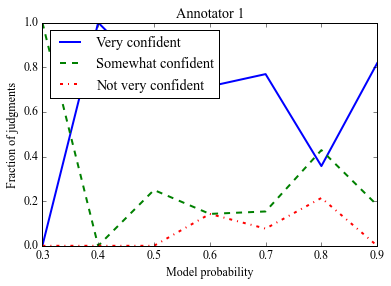

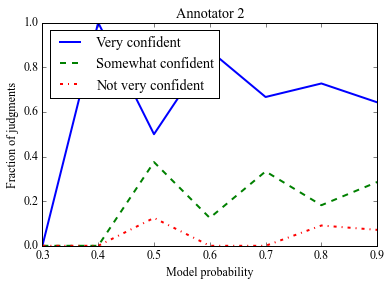

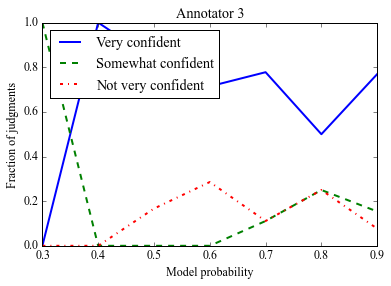

In [34]:
def plot_model_probabilities_conditioned_on_annotator_confidence():
    from collections import defaultdict
    
    df, _ = build_annotators_df()
    bins = np.linspace(0, 1, 9)
    
    conf_levels = df.confidence[df['confidence'].notnull()].unique()
    
    linestyles = [next(linestyle) for c in conf_levels]
    
    for annotator_id in [1, 2, 3]:
        # Get a data frame for just this annotator.
        annotator_df = df[df.annotator_id == annotator_id]
        
        # Get a data frame for the model itself.
        model_df = df[df.annotator_id == model_annotator_id].copy()
        
        # Retain only those rows in the model data frame for which the
        # given annotator provided a judgment.
        model_df = model_df[model_df.sent_id.isin(annotator_df.sent_id)]

        # Sort both data frames.
        annotator_df.sort('sent_id', inplace=True)
        model_df.sort('sent_id', inplace=True)
        
        # Copy the annotator's confidence to the model data frame.
        model_df.confidence = annotator_df.confidence
        
        # Iterate over the probability space in steps of 0.1.
        min_prob = model_df.probability.min()
        start_prob = 0.1 + int(min_prob / 0.1) * 0.1
        probs = np.arange(start_prob, 1.0, 0.1)
        
        fractions = defaultdict(list)
        
        for prob in probs:
            # Take the subset of model_df that falls in this range.
            model_prob_df = model_df[(model_df.probability > prob - 0.1) & (model_df.probability <= prob)]
            
            counts = np.zeros_like(conf_levels)
            
            for i, conf_level in enumerate(conf_levels):
                count = len(model_prob_df[model_prob_df.confidence == conf_level])
                counts[i] = count
                
            if counts.sum() > 0:
                normalized = counts / float(counts.sum())
            else:
                normalized = np.zeros_like(counts)
            
            for i, conf_level in enumerate(conf_levels):
                fractions[conf_level].append(normalized[i])
                
        plt.figure()
        for i, conf_level in enumerate(conf_levels):  
            plt.plot(probs, fractions[conf_level], label=conf_level, ls=linestyles[i], linewidth=2)
        plt.xlabel('Model probability')
        plt.ylabel('Fraction of judgments')
        plt.title('Annotator ' + str(annotator_id))
        plt.legend(loc='upper left')

plot_model_probabilities_conditioned_on_annotator_confidence()

In [35]:
def find_disagreement(df, agree_id1, agree_id2, disagree_id, column='correct_preposition'):
    df_agree1 = df[df.annotator_id == agree_id1]
    df_agree2 = df[df.annotator_id == agree_id2]
    df_disagree = df[df.annotator_id == disagree_id]
    
    sent_ids_agree1 = set(df_agree1.sent_id)
    sent_ids_agree2 = set(df_agree2.sent_id)
    sent_ids_disagree = set(df_disagree.sent_id)
    
    sent_ids = sent_ids_agree1.intersection(
            sent_ids_agree2).intersection(
                    sent_ids_disagree)
    
    # Make all data frames the same size with the same sentence ids.
    df_agree1 = df_agree1[df_agree1.sent_id.isin(sent_ids)]
    df_agree2 = df_agree2[df_agree2.sent_id.isin(sent_ids)]
    df_disagree = df_disagree[df_disagree.sent_id.isin(sent_ids)]
    
    agree = df_agree1[column].values == df_agree2[column].values
    disagree = df_agree1[column].values != df_disagree[column].values
    
    agreement_word = df_agree1[agree & disagree][column].values
    disagreement_word = df_disagree[agree & disagree][column].values
    sent_ids = df_disagree[agree & disagree].sent_id.values
    
    df_disagree = pd.DataFrame({
            'agreement_word': agreement_word,
            'disagreement_word': disagreement_word,
            'sent_id': sent_ids,
            'sent_is_modified': sent_is_modified(sent_ids)
        })
    
    df_disagree.sort('sent_id', inplace=True)
    
    return df_disagree
            
def build_sentence_error_df():
    df, sent_df = build_annotators_df()
    
    # For each annotator, find the sentences where the annotator 
    # and model agree with each other and disagree with the corpus.
    for annotator_id in [1, 2]:
        df_disagree = find_disagreement(df, annotator_id, model_annotator_id, corpus_annotator_id)
        sentences = sent_df[sent_df.sent_id.isin(df_disagree.sent_id)].sentence.values
        df_disagree['sentence'] = sentences

        print('Annotator {id} and model agree, disagree with corpus on {n} sentences'.format(
                id=annotator_id, n=len(df_disagree)))
        print('Showing first five')
        print('---------------')
        for i in np.arange(5):
            print('({modified}) ({id},model) {agreement} != (corpus) {disagreement} "{sentence}"\n'.format(
                modified='modified' if df_disagree.ix[i, 'sent_is_modified'] else 'not modified',
                id=annotator_id,
                agreement=df_disagree.ix[i, 'agreement_word'],
                disagreement=df_disagree.ix[i, 'disagreement_word'],
                sentence=df_disagree.ix[i, 'sentence']))
    
    # For each annotator, find the sentences where the annotator and model
    # disagree with each other and the annotator agrees with the corpus.
    for annotator_id in [1, 2]:
        df_disagree = find_disagreement(df, annotator_id, corpus_annotator_id, model_annotator_id)
        sentences = sent_df[sent_df.sent_id.isin(df_disagree.sent_id)].sentence.values
        df_disagree['sentence'] = sentences

        print('Annotator {id} and corpus agree, disagree with model on {n} sentences'.format(
                id=annotator_id, n=len(df_disagree)))
        print('Showing first five')
        print('---------------')
        for i in np.arange(5):
            print('({modified}) ({id},corpus) {agreement} != (model) {disagreement} "{sentence}"\n'.format(
                modified='modified' if df_disagree.ix[i, 'sent_is_modified'] else 'not modified',
                id=annotator_id,
                agreement=df_disagree.ix[i, 'agreement_word'],
                disagreement=df_disagree.ix[i, 'disagreement_word'],
                sentence=df_disagree.ix[i, 'sentence']))
    
    # For each annotator, find the sentences where the annotator and model
    # disagree with each other and the model agrees with the corpus.
    for annotator_id in [1, 2]:
        df_disagree = find_disagreement(df, model_annotator_id, corpus_annotator_id, annotator_id)
        sentences = sent_df[sent_df.sent_id.isin(df_disagree.sent_id)].sentence.values
        df_disagree['sentence'] = sentences

        print('Model and corpus agree, disagree with {id} on {n} sentences'.format(
                id=annotator_id, n=len(df_disagree)))
        print('Showing first five')
        print('---------------')
        for i in np.arange(5):
            print('({modified}) (model,corpus) {agreement} != ({id}) {disagreement} "{sentence}"\n'.format(
                modified='modified' if df_disagree.ix[i, 'sent_is_modified'] else 'not modified',
                id=annotator_id,
                agreement=df_disagree.ix[i, 'agreement_word'],
                disagreement=df_disagree.ix[i, 'disagreement_word'],
                sentence=df_disagree.ix[i, 'sentence']))
    
build_sentence_error_df()

Annotator 1 and model agree, disagree with corpus on 22 sentences
Showing first five
---------------
(not modified) (1,model) by != (corpus) on "thus the manors of hethersett , which had been settled on thomas flowerdew of london , merchant , after having been mortgaged to william gostlin , were sold in digitdigitdigitdigit to captain john aide of horstead ."

(not modified) (1,model) on != (corpus) in "daichi and shiroh have become rivals after they first met and work together in some occasions ."

(not modified) (1,model) by != (corpus) of "it is also a reason the city was chosen as the winter white house of president harry s. truman ."

(not modified) (1,model) in != (corpus) of "halbi or halba is a tribal community of india ."

(modified) (1,model) on != (corpus) at "the three story brick building occupies a prominent location in the business district ; its most distinctive feature , a four story clock tower with the corner of central and court streets , makes it a local landmark .

In [36]:
def report_annotator_results(annotator_csv, annotator_id, model_data, preds, probs, target_data):
    annotator_df = load_annotator_df(annotator_csv)
    new_df = merge_ground_truth_and_judgments(
            annotator_df, annotator_id, model_data, preds, probs, target_data)
    
    print('Annotator {id} vs. ground truth'.format(id=annotator_id))
    p, r, f1, _ = precision_recall_fscore_support(
        new_df.ground_truth_word_code, new_df.annotator_word_code, average='macro')
    k = cohen_kappa_score(new_df.ground_truth_word_code, new_df.annotator_word_code)
    print('P {precision:.02f} R {recall:.02f} F1 {f1:.02f} Kappa {kappa:.02f}'.format(
            precision=p, recall=r, f1=f1, kappa=k))

    print('Model vs. ground truth')
    p, r, f1, _ = precision_recall_fscore_support(
        new_df.ground_truth_word_code, new_df.model_word_code, average='macro')
    k = cohen_kappa_score(new_df.ground_truth_word_code, new_df.model_word_code)
    print('P {precision:.02f} R {recall:.02f} F1 {f1:.02f} Kappa {kappa:.02f}'.format(
            precision=p, recall=r, f1=f1, kappa=k))

    print('Model vs. annotator {id}'.format(id=annotator_id))
    p, r, f1, _ = precision_recall_fscore_support(
        new_df.annotator_word_code, new_df.model_word_code, average='macro')
    k = cohen_kappa_score(new_df.annotator_word_code, new_df.model_word_code)
    print('P {precision:.02f} R {recall:.02f} F1 {f1:.02f} Kappa {kappa:.02f}'.format(
            precision=p, recall=r, f1=f1, kappa=k))


Annotator 1
----------

In [37]:
# annotator1_csv = annotator_data_dir + 'annotator01-results.csv'
# report_annotator_results(
#     annotator1_csv, 1,
#     model_data, preds, probs, target_data)

Annotator 2
-----------

In [38]:
# annotator2_csv = annotator_data_dir + 'annotator02-results.csv'
# report_annotator_results(
#     annotator2_csv, 2,
#     model_data, preds, probs, target_data)

In [39]:
# annotator_csvs = [annotator1_csv, annotator2_csv]
# annotator_ids = [1, 2]
# all_annotators = merge_ground_truth_and_multiple_judgments(
#     annotator_csvs, annotator_ids, model_data, preds, target_data)